In [1]:
!pip uninstall torchvision

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
%%capture
# Install PyTorch with CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install additional dependencies
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

# Install package for creating visually distinct colormaps
!pip install distinctipy

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

In [6]:
!sudo apt-get update
!sudo apt-get install unzip

[sudo] password for midtempo: 
[sudo] password for midtempo: 

In [4]:
!unzip ./trained-model/mask-r-cnn-trained.zip

unzip:  cannot find or open ./trained-model/mask-r-cnn-trained.zip, ./trained-model/mask-r-cnn-trained.zip.zip or ./trained-model/mask-r-cnn-trained.zip.ZIP.


In [2]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Define the relative path to the model file
relative_path = 'trained-model/content/pytorch-mask-r-cnn-instance-segmentation/2024-04-27_18-10-33/maskrcnn_resnet50_fpn_v2.pth'

# Construct the full path to the model file
MASK_RCNN_MODEL_PATH = os.path.join(current_directory, relative_path)

print(MASK_RCNN_MODEL_PATH)

/home/midtempo/Mask-RCNN/trained-model/content/pytorch-mask-r-cnn-instance-segmentation/2024-04-27_18-10-33/maskrcnn_resnet50_fpn_v2.pth


In [3]:
# Import Python Standard Library dependencies
import datetime
from functools import partial
from glob import glob
import json
import math
import multiprocessing
import os
from pathlib import Path
import random
from typing import Any, Dict, Optional

# Import utility functions
from cjm_psl_utils.core import download_file, file_extract, get_source_code
from cjm_pil_utils.core import resize_img, get_img_files, stack_imgs
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, get_torch_device, set_seed, denorm_img_tensor, move_data_to_device
from cjm_pandas_utils.core import markdown_to_pandas, convert_to_numeric, convert_to_string
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchtnt.utils import get_module_summary
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import tqdm for progress bar
from tqdm.auto import tqdm

## 2. Load the model

### 2.1 Install protobuf

In [ ]:
# Install dependencies required for protobuf compilation
sudo apt-get update
sudo apt-get install -y autoconf automake libtool curl make g++ unzip

# Download protobuf 3.20 source code
wget https://github.com/protocolbuffers/protobuf/releases/download/v3.20.0/protobuf-all-3.20.0.tar.gz

# Extract the downloaded tarball
tar -xvzf protobuf-all-3.20.0.tar.gz

# Change directory to the extracted protobuf directory
cd protobuf-3.20.0

# Configure the build
./configure

# Compile protobuf
make

# Run tests
make check

# Install protobuf
sudo make install

# Update shared library cache
sudo ldconfig

# Verify protobuf installation
protoc --version

In [1]:
!protoc --version

libprotoc 3.20.1


### 2.2. Setup Dependencies

In [5]:
%%capture
# Install PyTorch with CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Install additional dependencies
!pip install pandas pillow

# Install ONNX packages
!pip install onnx onnxruntime onnx-simplifier

# Install utility packages
!pip install cjm_psl_utils cjm_pil_utils

In [ ]:
!pip install matplotlib pandas pillow torchtnt==0.2.0 tqdm tabulate

In [ ]:
!pip install onnx onnxruntime onnx-simplifier

In [ ]:
!pip install onnxruntime-gpu --extra-index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/


In [ ]:
# Download Onyx.
git clone https://github.com/onyx-lang/onyx --depth 1
cd onyx
# Load settings used for compilation. Change these settings if you would like.
source settings.sh
# Compile and install Onyx.
./build.sh compile install

In [1]:
# Import Python Standard Library dependencies
import json
from pathlib import Path
import random

# Import utility functions
from cjm_psl_utils.core import download_file
from cjm_pil_utils.core import resize_img

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Import PIL for image manipulation
from PIL import Image, ImageDraw, ImageFont

# Import PyTorch dependencies
import torch

# Import Mask R-CNN
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Import ONNX dependencies
import onnx # Import the onnx module
from onnxsim import simplify # Import the method to simplify ONNX models
import onnxruntime as ort # Import the ONNX Runtime

## Setting Up the Project
### Set the Directory Paths

In [2]:
from pathlib import Path

# Get the current working directory
current_directory = Path.cwd()

project_name = f"pytorch-mask-r-cnn-instance-segmentation"

# The path for the project folder
project_dir = Path(f"./trained-model/content/{project_name}/")

# Create the project directory if it does not already exist
project_dir.mkdir(parents=True, exist_ok=True)

# The path to the checkpoint folder
checkpoint_dir = Path(project_dir/f"2024-04-27_18-10-33/")

pd.Series({
    "Project Directory:": project_dir,
    "Checkpoint Directory:": checkpoint_dir,
}).to_frame().style.hide(axis='columns')

### Download a Font File

In [3]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

The file ./KFOlCnqEu92Fr1MmEU9vAw.ttf already exists and overwrite is set to False.


In [ ]:
## Load the Colormap

In [4]:
# The colormap path
colormap_path = list(checkpoint_dir.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
        colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

## Load the Model Checkpoint

In [5]:

# The model checkpoint path
checkpoint_path = list(checkpoint_dir.glob('*.pth'))[0]

# Load the model checkpoint onto the CPU
model_checkpoint = torch.load(checkpoint_path, map_location='cpu')

In [6]:

# Initialize a Mask R-CNN model
model = maskrcnn_resnet50_fpn_v2(weights='DEFAULT')

# Get the number of input features for the classifier
in_features_box = model.roi_heads.box_predictor.cls_score.in_features
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# Replace the box predictor
model.roi_heads.box_predictor = FastRCNNPredictor(in_features_box, len(class_names))

# Replace the mask predictor
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_channels=in_features_mask, dim_reduced=256, num_classes=len(class_names))

# Initialize the model with the checkpoint parameters and buffers
model.load_state_dict(model_checkpoint)

<All keys matched successfully>

## Exporting the Model to ONNX

In [7]:

model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

## Prepare the Input Tensor

In [8]:
input_tensor = torch.randn(1, 3, 256, 256)

## Export the Model to ONNX

In [9]:

# Set a filename for the ONNX model
onnx_file_path = f"{checkpoint_dir}/{colormap_path.stem.removesuffix('-colormap')}-{checkpoint_path.stem}.onnx"

# Export the PyTorch model to ONNX format
torch.onnx.export(model.cpu(),
                  input_tensor.cpu(),
                  onnx_file_path,
                  export_params=True,
                  do_constant_folding=False,
                  input_names = ['input'],
                  output_names = ['boxes', 'labels', 'scores', 'masks'],
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

/home/midtempo/miniconda3/envs/py-39/lib/python3.9/site-packages/torch/nn/functional.py:4009: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
/home/midtempo/miniconda3/envs/py-39/lib/python3.9/site-packages/torchvision/ops/boxes.py:166: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/midtempo/miniconda3/envs/py-39/lib/python3.9/site-packages/torchvision/ops/boxes.py:168: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().

## Simplify the ONNX Model

In [10]:
# Load the ONNX model from the onnx_file_name
onnx_model = onnx.load(onnx_file_path)

# Simplify the model
model_simp, check = simplify(onnx_model)

# Save the simplified model to the onnx_file_name
onnx.save(model_simp, onnx_file_path)


## Performing Inference with ONNX Runtime
### Create an Inference Session

In [11]:
session = ort.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])

2024-05-30 22:22:36.979617423 [W:onnxruntime:, graph.cc:4093 CleanUnusedInitializersAndNodeArgs] Removing initializer '3114'. It is not used by any node and should be removed from the model.


In [13]:
def draw_bboxes_pil(image, boxes, labels, colors, font, width:int=2, font_size:int=18, probs=None):
    """
    Annotates an image with bounding boxes, labels, and optional probability scores.

    This function draws bounding boxes on the provided image using the given box coordinates, 
    colors, and labels. If probabilities are provided, they will be added to the labels.

    Parameters:
    image (PIL.Image): The input image on which annotations will be drawn.
    boxes (list of tuples): A list of bounding box coordinates where each tuple is (x, y, w, h).
    labels (list of str): A list of labels corresponding to each bounding box.
    colors (list of str): A list of colors for each bounding box and its corresponding label.
    font (str): Path to the font file to be used for displaying the labels.
    width (int, optional): Width of the bounding box lines. Defaults to 2.
    font_size (int, optional): Size of the font for the labels. Defaults to 25.
    probs (list of float, optional): A list of probability scores corresponding to each label. Defaults to None.

    Returns:
    annotated_image (PIL.Image): The image annotated with bounding boxes, labels, and optional probability scores.
    """
    
    # Define a reference diagonal
    REFERENCE_DIAGONAL = 1000
    
    # Scale the font size using the hypotenuse of the image
    font_size = int(font_size * (np.hypot(*image.size) / REFERENCE_DIAGONAL))
    
    # Add probability scores to labels
    if probs is not None:
        labels = [f"{label}: {prob*100:.2f}%" for label, prob in zip(labels, probs)]
    
    # Create a copy of the image
    annotated_image = image.copy()

    # Create an ImageDraw object for drawing on the image
    draw = ImageDraw.Draw(annotated_image)

    # Loop through the bounding boxes and labels in the 'annotation' DataFrame
    for i in range(len(labels)):
        # Get the bounding box coordinates
        x, y, x2, y2 = boxes[i]

        # Create a tuple of coordinates for the bounding box
        shape = (x, y, x2, y2)

        # Draw the bounding box on the image
        draw.rectangle(shape, outline=colors[i], width=width)
        
        # Load the font file
        fnt = ImageFont.truetype(font, font_size)
        
        # Draw the label box on the image
        label_w, label_h = draw.textbbox(xy=(0,0), text=labels[i], font=fnt)[2:]
        draw.rectangle((x, y-label_h, x+label_w, y), outline=colors[i], fill=colors[i], width=width)

        # Draw the label on the image
        draw.multiline_text((x, y-label_h), labels[i], font=fnt, fill='black' if np.mean(colors[i]) > 127.5 else 'white')
        
    return annotated_image



## Select a Test Image

In [26]:
test_img_name = "trained-model/images/bb1.jpg"

test_img = Image.open(test_img_name)
# display(test_img)

image_data = pd.Series({
    "Test Image Size:": test_img.size, 
    "Check": 123
}).to_frame().style.hide(axis='columns')

In [27]:
print(image_data.index)

Index(['Test Image Size:', 'Check'], dtype='object')


In [29]:
print(image_data.data.iloc[0, 0])

123


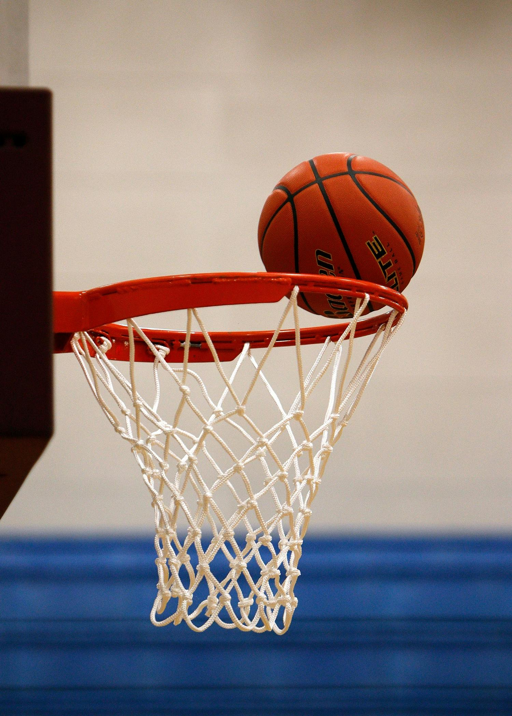

In [15]:
# Set test image size
test_sz = 512

## Resize the test image
input_img = resize_img(test_img, target_sz=test_sz, divisor=1)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.size)

display(input_img)

# Print the prediction data as a Pandas DataFrame for easy formatting
pd.Series({
    "Source Image Size:": test_img.size,
    "Input Dims:": input_img.size,
    "Min Image Scale:": min_img_scale,
    "Input Image Size:": input_img.size
}).to_frame().style.hide(axis='columns')

## Prepare the Input Tensor

## Prepare the Test Image

In [16]:
# Convert the input image to NumPy format
input_tensor_np = np.array(input_img, dtype=np.float32).transpose((2, 0, 1))[None]/255

## Compute the Predictions

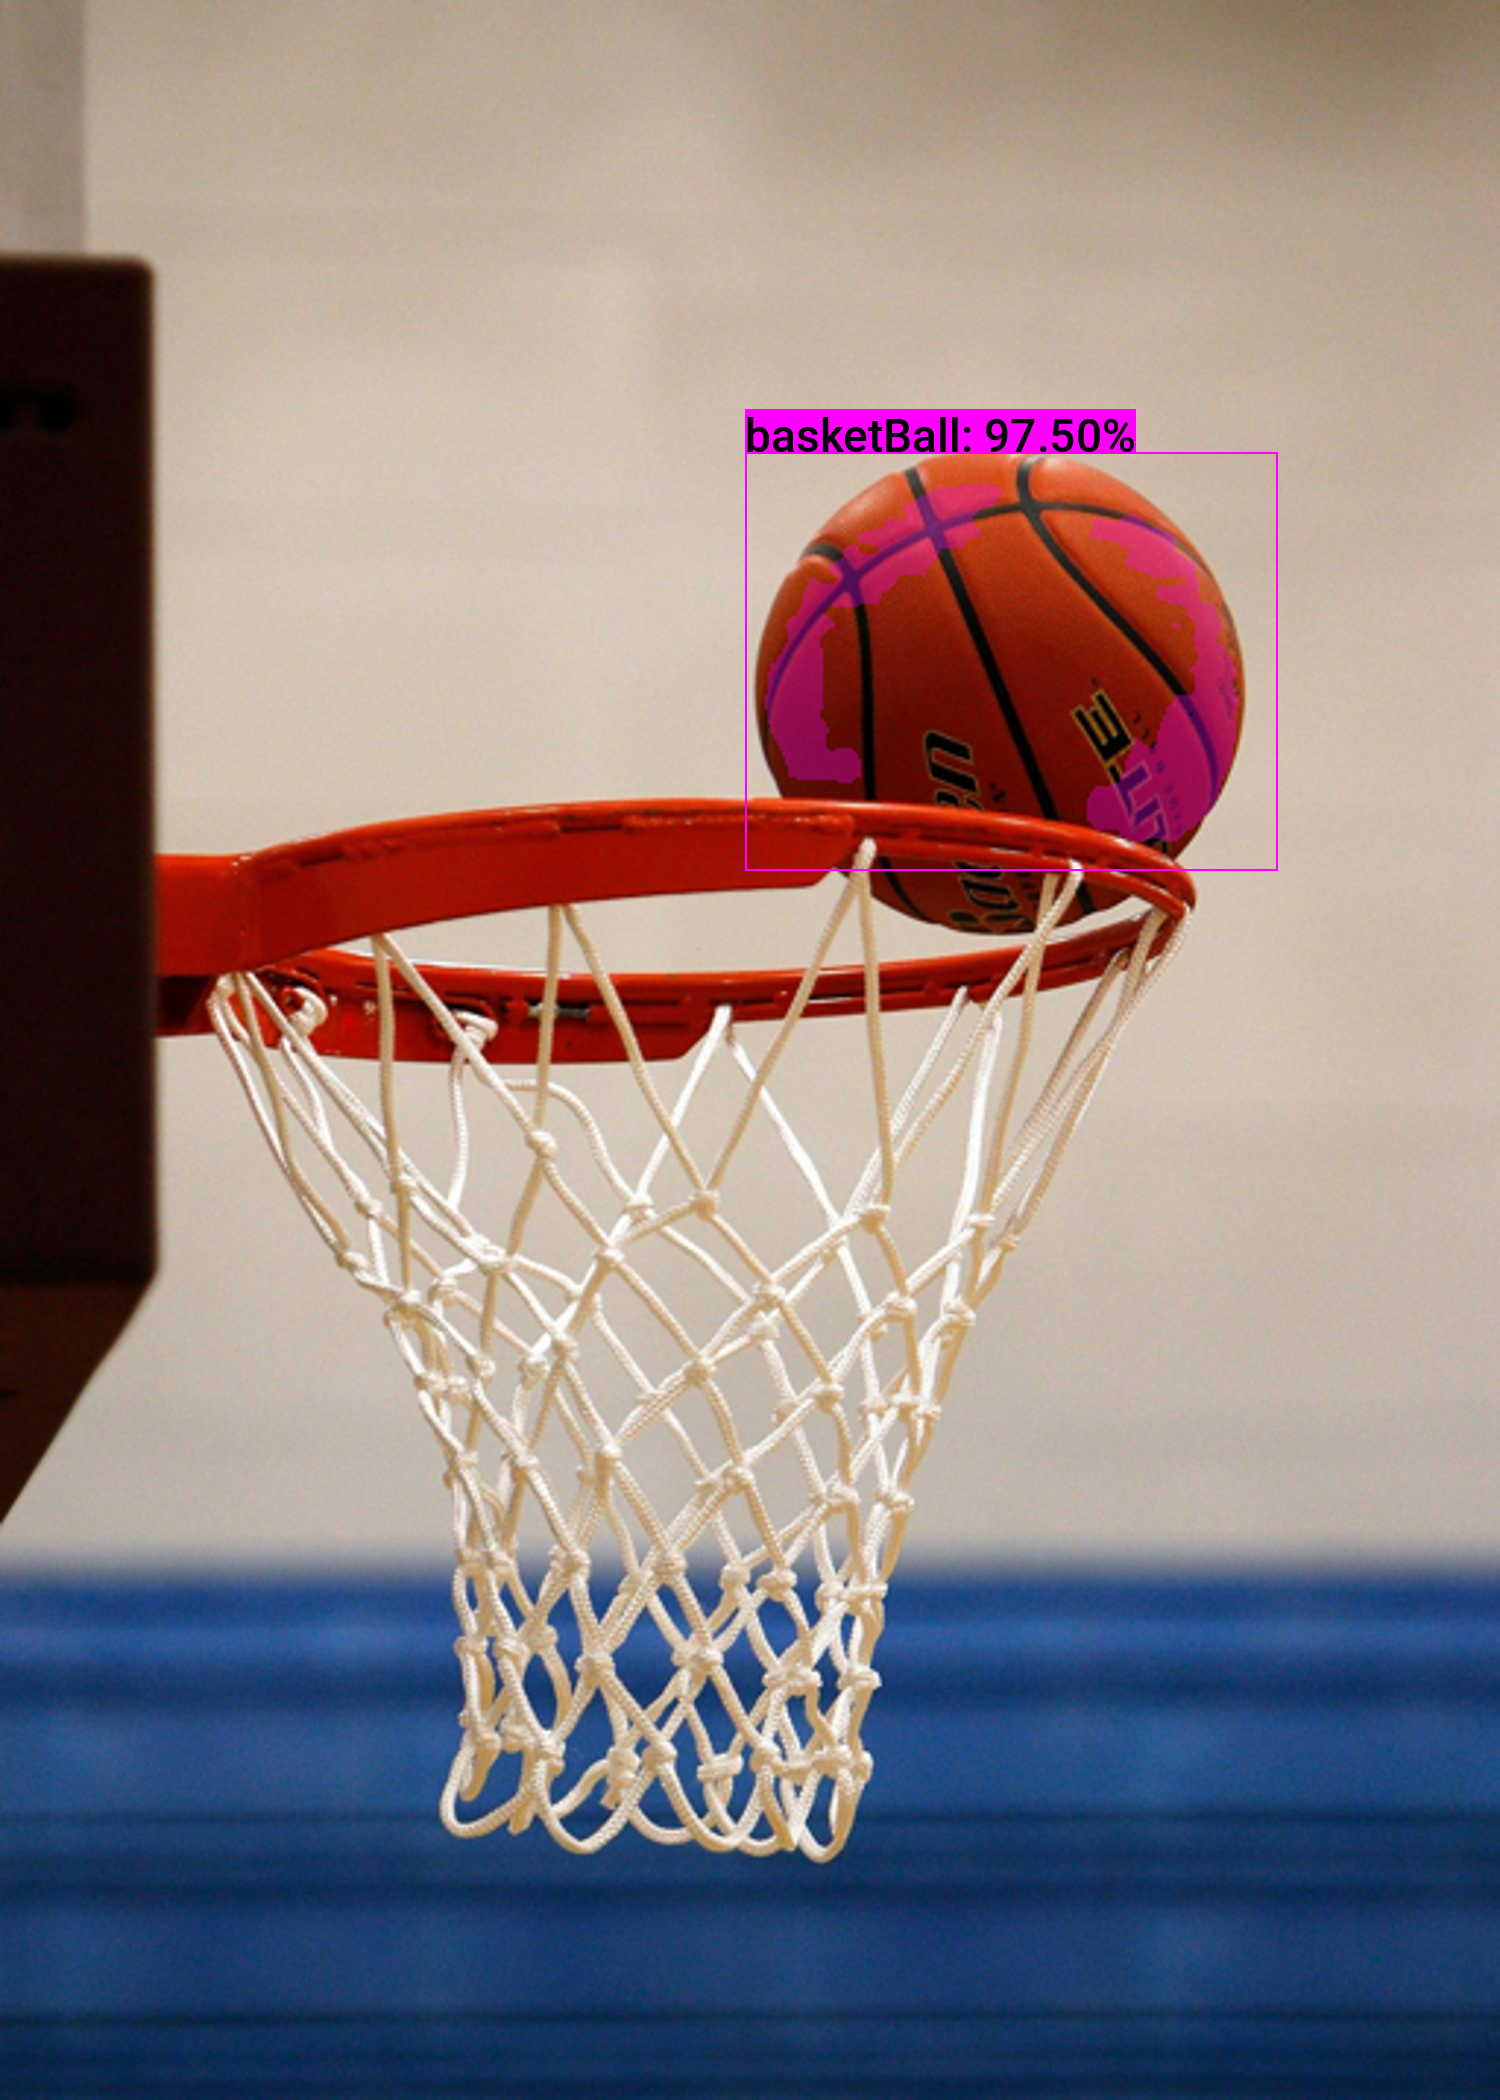

In [32]:
# Run inference
model_output = session.run(None, {"input": input_tensor_np})

# Set the confidence threshold
threshold = 0.45

# Filter the output based on the confidence threshold
scores_mask = model_output[2] > threshold

bbox_list = (model_output[0][scores_mask])*min_img_scale
label_list = [class_names[int(idx)] for idx in model_output[1][scores_mask]]
probs_list = model_output[2]

colors = [int_colors[class_names.index(i)] for i in label_list]

annotated_img = draw_masks_pil(input_img, model_output[-1], label_list, colors, alpha=0.3)
annotated_img = annotated_img.resize(test_img.size)

annotated_img = draw_bboxes_pil(
    image=annotated_img, 
    boxes=bbox_list, 
    labels=label_list,
    probs=probs_list,
    colors=colors, 
    font=font_file,
)

display(annotated_img)

# Print the prediction data as a Pandas Series for easy formatting
prediction_result_with_bboxes = pd.Series({
    "Predicted BBoxes:": [f"{label}:{bbox}" for label, bbox in zip(label_list, bbox_list.round(decimals=3))],
    "Confidence Scores:": [f"{label}: {prob}" for label, prob in zip(label_list, probs_list)]
}).to_frame().style.hide(axis='columns')

In [44]:
import pandas as pd
from enum import Enum
from decimal import Decimal

class LabelEnum(Enum):
    basketBall = "basketBall"

predictions = prediction_result_with_bboxes.data.iloc[1, 0][0].strip("[]")
predictions

label, value = predictions.split(":")
label = label.strip()
value = Decimal(value.strip())

print(label, value)

basketBall 0.9749793410301208
